Energy Demand Prediction

~ A Time Series Analysis for Efficient Resource Management ~

ㅤ

This project entails having an AI model train from data and predict energy consumption in Ontario, Canada.

But, firstly, why is this important? Forecasting energy demand in areas definitely is an important thing to ensure a sustainable and efficient power grid. 

Having a model accurately predict energy consumtion can allow us to manage our resources more effectively and reduce wastage.

In this project, we will be using a dataset (from kaggle) called Ontario Electricity Demand. We will use this dataset to predict energy consumption for the future.



ㅤ

First, we will import our libraries. 

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [288]:
from sklearn.metrics import mean_squared_error

In [289]:
%pip install xgboost
import xgboost as xgb

Note: you may need to restart the kernel to use updated packages.


Next, let's import the dataset that we will be using.

In [291]:
df = pd.read_csv('ontario_electricity_demand.csv')

In [292]:
df.head()

,date,hour,hourly_demand,hourly_average_price
0,2002-05-01,1,14137000,22.97
1,2002-05-01,2,13872000,23.27
2,2002-05-01,3,13820000,24.54
3,2002-05-01,4,13744000,15.17
4,2002-05-01,5,14224000,23.59


We can see that this dataset starts around mid 2002,

In [294]:
df.tail()

,date,hour,hourly_demand,hourly_average_price
183427,2023-04-03,20,16590000,27.78
183428,2023-04-03,21,16140000,38.68
183429,2023-04-03,22,15434000,82.19
183430,2023-04-03,23,14355000,36.37
183431,2023-04-03,24,13755000,33.56


and ends in April, 2023. Looks like we have about 21 years of data to work with.

We should set the DataFrame's index to show the date and time as one column to focus on what we're going to be looking at.
We should also remove hourly average price because we won't be needing it.

In [297]:
df["Datetime"] = pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour"] - 1, unit="h")
df = df.drop(columns=["date", "hour", "hourly_average_price"])
df.set_index("Datetime", inplace=True)
print(df.head())

                     hourly_demand
Datetime                          
2002-05-01 00:00:00       14137000
2002-05-01 01:00:00       13872000
2002-05-01 02:00:00       13820000
2002-05-01 03:00:00       13744000
2002-05-01 04:00:00       14224000




Now, let's create the plot. We can set the separate axis to be scaled for every 5 years, and to show the actual amount of KW used every hour. 
We should also label the axis and give this plot a title. 



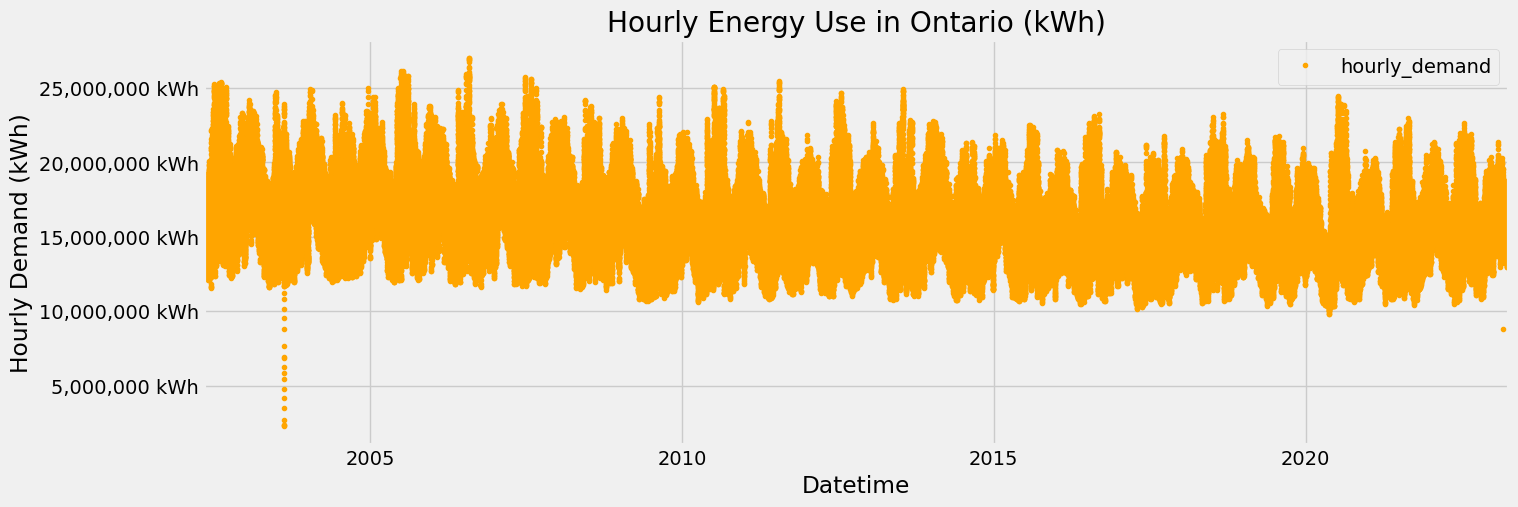

In [299]:
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(ax=ax, style='.', color='orange', title='Hourly Energy Use in Ontario (kWh)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,} kWh"))
ax.set_ylabel("Hourly Demand (kWh)")
ax.set_xlabel("Datetime")
plt.show()

Train/Test Split:

To ensure the AI is trained on information to predict, it needs a portion of the data to train it, and the other portion to test. We can split
the data at the year 2019, so we will have the AI train on the data from 2002-2019, and test on the data from 2019-2023. 

In [302]:
train = df.loc[df.index < '01-01-2019']
test = df.loc[df.index >= '01-01-2019'] 

It would also be nice for us to see this data, so let's quickly plot it down.

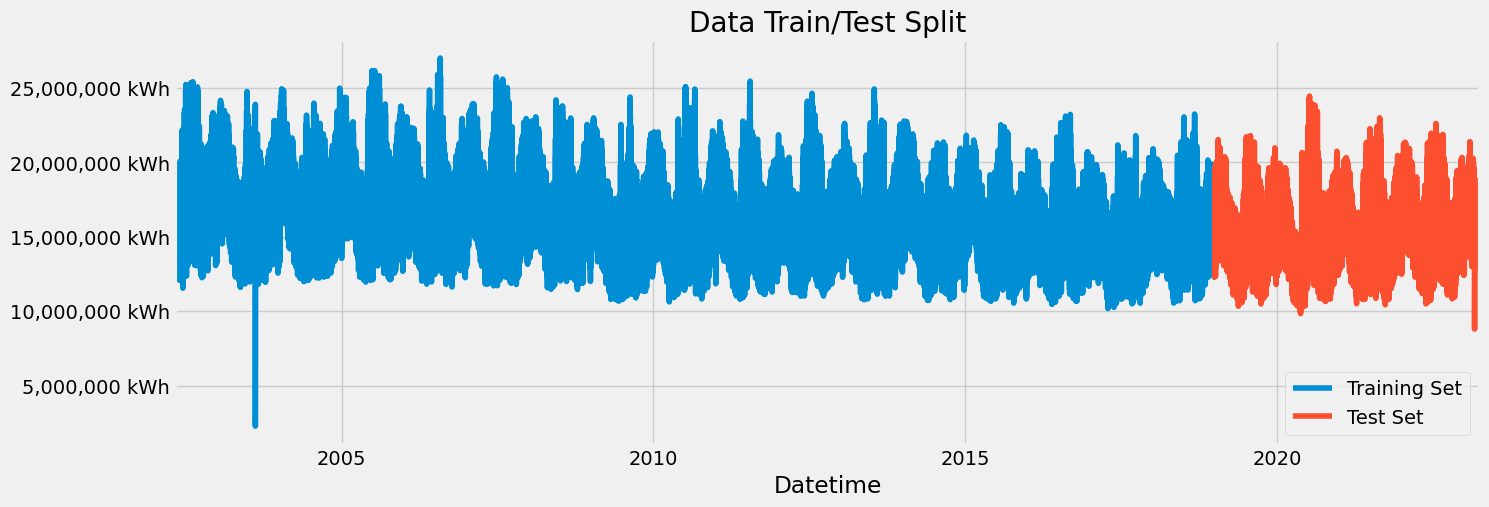

In [304]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,} kWh"))
train.plot(ax=ax,label='Training',title = 'Data Train/Test Split')
test.plot(ax=ax,label='Testing')
ax.legend(['Training Set', 'Test Set'])
plt.show()

So, now to analyze our training data more. We want to see the exact relationship between the time and the energy consumption. 

To do this, we'll need to take a closer look at a days energy usage, then a month, then a year. 

To make this easier, I am going to create a function that plots the energy consumption for a specific period of time, so that I can do this repeatedly for a week, month, and year.

In [307]:
def plot_energy_consumption(df, start_date, end_date, title):
    
    period_data = df.loc[start_date:end_date]
    plt.figure(figsize=(15, 5))
    plt.plot(period_data.index, period_data['hourly_demand'], marker='.', linestyle='-', color='blue')
    plt.title(title)
    plt.ylabel("Hourly Demand (MW)")
    plt.xlabel("Datetime")
    plt.grid(True)
    plt.show()

Plot for a single week:

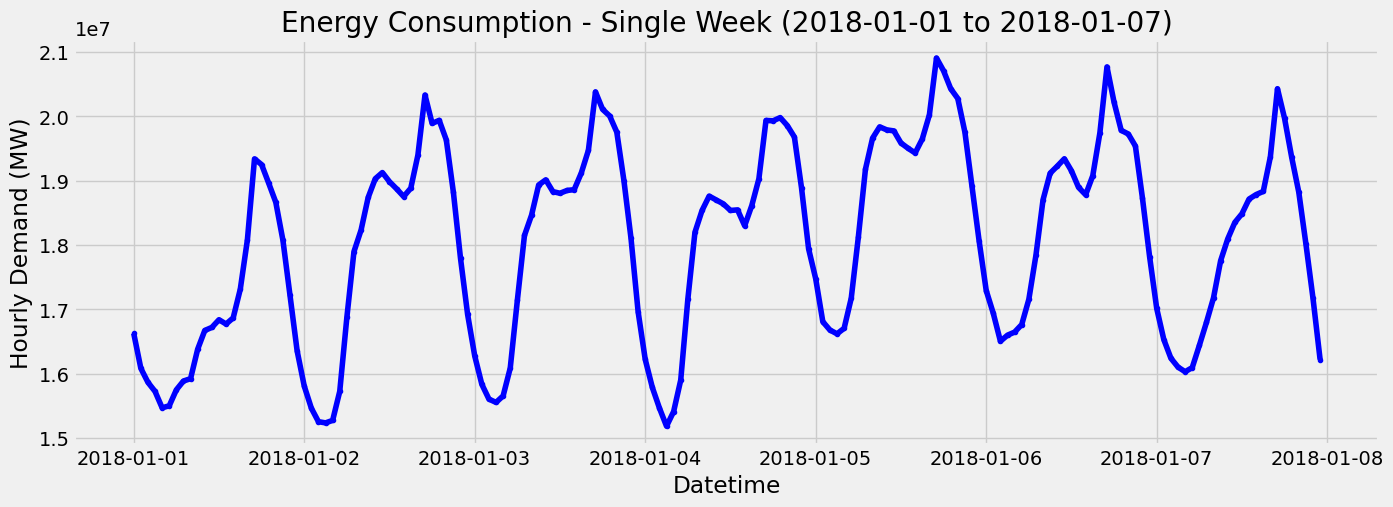

In [309]:
plot_energy_consumption(df, "2018-01-01", "2018-01-07", "Energy Consumption - Single Week (2018-01-01 to 2018-01-07)")

Plot for a single month:

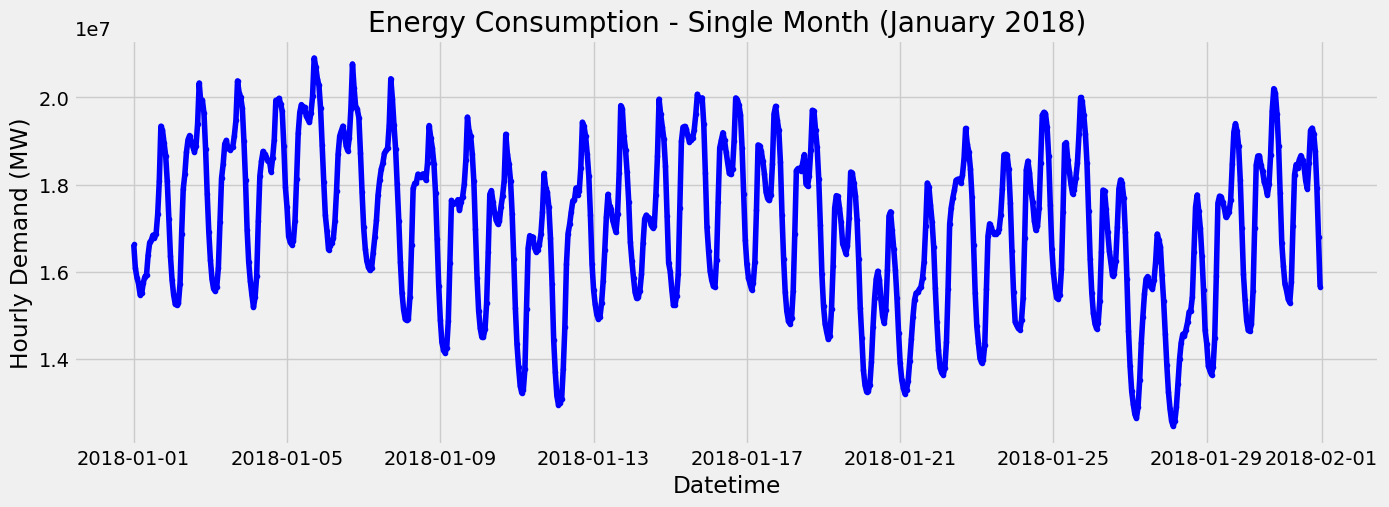

In [355]:
plot_energy_consumption(df, "2018-01-01", "2018-01-31", "Energy Consumption - Single Month (January 2018)")

Plot for a single year:

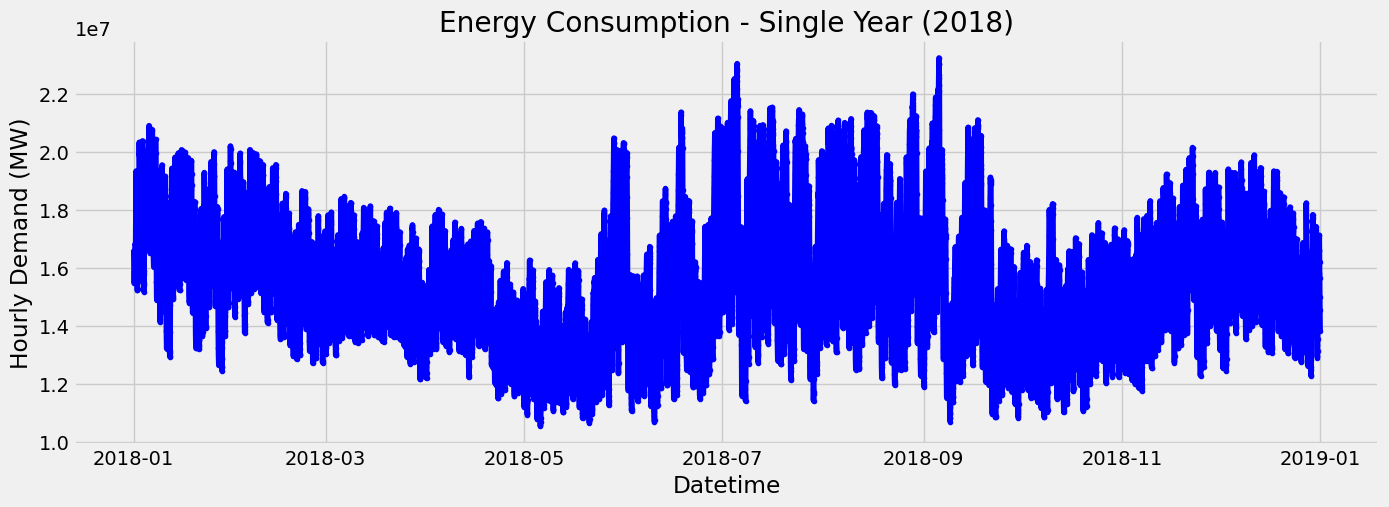

In [313]:
plot_energy_consumption(df, "2018-01-01", "2018-12-31", "Energy Consumption - Single Year (2018)")

Creating the model:

Let's create a function that gives time series features based on the time series index.

In [316]:
def features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df = features(df)

Let's have our training dataset and testing datasets obtain these features from the function.

In [318]:
train = features(train)
test = features(test)

Here is a list of features that correspond to datetime's scales, and a single string target which is the hourly demand.

In [320]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'hourly_demand'

Now we're going to make a features dataset from the training dataset. x_train is all of the features from the training dataset, and y_train
is our target column from our dataset.

In [322]:
x_train = train[features]
y_train = train[target]

Let's do the same for the testing datasets.

In [324]:
x_test = test[features]
y_test = test[target]

Now it's actually time to train the datasets.

In [326]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[0]	validation_0-rmse:2594570.42897	validation_1-rmse:2538359.15948
[100]	validation_0-rmse:1585032.61955	validation_1-rmse:1704733.32616
[200]	validation_0-rmse:1263770.02364	validation_1-rmse:1406629.86908
[300]	validation_0-rmse:1119497.03765	validation_1-rmse:1271875.72632
[400]	validation_0-rmse:1030804.83381	validation_1-rmse:1222372.64862
[500]	validation_0-rmse:978640.29014	validation_1-rmse:1208439.68457
[600]	validation_0-rmse:946389.60241	validation_1-rmse:1206642.79930
[663]	validation_0-rmse:926271.59347	validation_1-rmse:1209795.59530


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance:

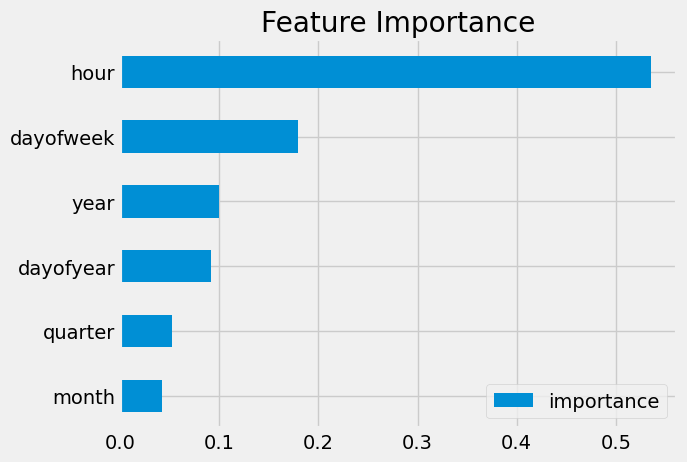

In [328]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

Forecasting:

It's time to start predicting energy consumption!

In [331]:
test['prediction']=reg.predict(x_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

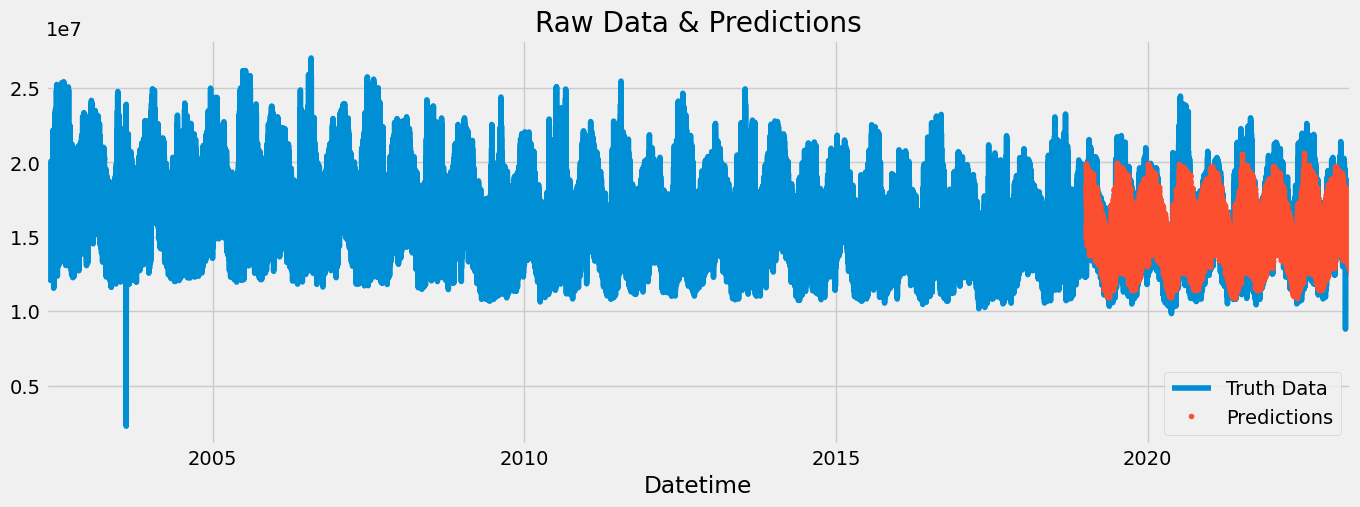

In [332]:
ax = df[['hourly_demand']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data & Predictions')
plt.show()

Well, the prediction has the general shape and behaviours of the actual data, so it's not far off at all.

However, there are some discrepencies visible, like the peak in the middle of 2020. The model could definitely benefit from getting individual data from days or even stretches of specific time where energy use will hit a peak, but that's just something that can sometimes be hard to predict.

ㅤ

Final Thoughts:

In the end, we were able to predict the energy consumption from 2019-2023 to a certain extent. 
While we definitely gauged the relationship of how energy fluctuates to a decent degree, there is still room for improvement in certain cases. 
I learned that it is definitely possible for models to predict occurrences of events in the near future, 
so it gives me hope that the usage of past data can lead to how we tackle the future.